In [1]:
build = 'archive' # 'archive' uses the neurolibre archive of the data., 'latest' would download the latest versions of the data.
notebook = 'neurolibre-figures' # neurolibre-figures: no processing, use downloaded processed data and do figures & stats,
                                # neurolibre-clean: if some processed data exists, cleanup; Reprocess data
                                # colab: download and process data from scratch in Google Colab

try:
  import google.colab
  notebook = 'colab'
except:
  pass

<head>

<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=STIX+Two+Text:ital,wght@0,400;0,700;1,400&display=swap" rel="stylesheet">
</head>


<p>
<center>
<b>
<h1>
Analysis code for the paper "RF shimming in the cervical spinal cord at 7T"
</h1>
</b>

<p style="text-align:center">
Daniel Papp<sup>1</sup>, Kyle M. Gilbert<sup>2,3</sup>, Gaspard Cereza<sup>1</sup>, Alexandre D’Astous<sup>1</sup>, Mathieu Boudreau<sup>1</sup>, Marcus Couch<sup>4</sup>, Pedram Yazdanbakhsh<sup>5</sup>, Robert L. Barry<sup>6,7,8</sup>, Eva Alonso Ortiz<sup>1</sup>, Julien Cohen-Adad<sup>1,9,10</sup>
</p>
</b>

</center>

<p style="text-align:justify;font-size:70%">
<sup>1</sup>NeuroPoly Lab, Institute of Biomedical Engineering, Polytechnique Montreal, Montreal, QC, Canada,
<sup>2</sup> Centre for Functional and Metabolic Mapping, The University of Western Ontario, London, ON, Canada,
<sup>3</sup> Department of Medical Biophysics, The University of Western Ontario, London, ON, Canada,
<sup>4</sup> Siemens Healthcare Limited, Montreal, QC, Canada,
<sup>5</sup> McConnell Brain Imaging Centre, Montreal Neurological Institute, McGill University, Montreal, QC, Canada,
<sup>6</sup> Athinoula A. Martinos Center for Biomedical Imaging, Department of Radiology, Massachusetts General Hospital, Charlestown, MA, USA,
<sup>7</sup> Harvard Medical School, Boston, MA, USA,
<sup>8</sup> Harvard-Massachusetts Institute of Technology Health Sciences & Technology, Cambridge, MA, USA,
<sup>9</sup> Mila - Quebec AI Institute, Montreal, QC, Canada,
<sup>10</sup> Functional Neuroimaging Unit, Centre de recherche de l'Institut universitaire de gériatrie de Montréal QC, Canada

</p>
</p>
</p>


<center><h2>Summary</h2></center>

Data was collected from five participants between two 7T sites with a custom 8Tx/20Rx parallel transmission (pTx) coil. We explored two RF shimming approaches from an MRI vendor and four from an open-source toolbox, showcasing their ability to enhance transmit field and signal homogeneity along the cervical spinal cord.

The results indicate significant improvements in B1+ efficiency and cerebrospinal fluid / spinal cord signal ratio across various RF shimming conditions compared to the vendor based methods.

The study's findings highlight the potential of RF shimming to advance 7T MRI's clinical utility for central nervous system imaging by enabling more homogenous and efficient spinal cord imaging. Additionally, the research incorporates a reproducible Jupyter Notebook, enhancing the study's transparency and facilitating peer verification. By also making the data openly accessible on OpenNeuro, we ensure that the scientific community can further explore, validate, and build upon our findings, contributing to the collective advancement in high-resolution imaging techniques.

```{figure} ../featured.png
---
width: 900px
name: fig1
align: center
---
```

<p class="caption">
<b>Figure 1</b>. Overview of the RF shimming procedure. The top panel shows the RF coil used for the experiments, alongside the Tx coil geometry and the electromagnetic simulation results (on Gustav model) yielding the CP mode used for this coil. The bottom panel shows the RF shimming procedure (with approximate duration). First, GRE and tfl_rfmap scans are acquired (4min30s). Second, these images are transferred via ethernet socket from the MRI console onto a separate laptop running Shimming Toolbox and SCT (&#601s). Third, the spinal cord is automatically segmented to produce a mask that is resampled into the space of the individual coil magnitude and phase images of the tfl_rfmap scan (~5s). Fourth, the RF shim weights are calculated according to the defined constraints for each shim scenario (1min total).
</p>

<center><h2>Statement of Need</h2></center>

Advancing the development of 7T MRI for spinal cord imaging is crucial for the enhanced diagnosis and monitoring of various neurodegenerative diseases {cite:p}`Kearney2015-py` and traumas {cite:p}`David2019-jy`. However, a significant challenge at this field strength is the transmit field inhomogeneity {cite:p}`Ibrahim2001-xt,Collins2005-za,Roschmann1987-om,Yang2002-ui`. Such inhomogeneity is particularly problematic for imaging the small, deep anatomical structures of the cervical spinal cord , as it can cause uneven signal intensity and elevate the local specific absorption ratio, compromising image quality. This multi-site study explores several radiofrequency (RF) shimming techniques in the cervical spinal cord at 7T.


# 1 &nbsp; &nbsp; | &nbsp; &nbsp; Data

The data can be downloaded from: https://openneuro.org/datasets/ds004906

The structure of the input dataset is as follows (JSON sidecars are not listed for clarity):

```{toggle}
~~~
ds004906
├── CHANGES
├── README
├── dataset_description.json
├── participants.json
├── participants.tsv
├── sub-01
│   ├── anat
│   │   ├── sub-01_acq-CP_T1w.nii.gz
│   │   ├── sub-01_acq-CP_T2starw.nii.gz
│   │   ├── sub-01_acq-CoV_T1w.nii.gz
│   │   ├── sub-01_acq-CoV_T2starw.nii.gz
│   │   ├── sub-01_acq-SAReff_T2starw.nii.gz
│   │   ├── sub-01_acq-patient_T2starw.nii.gz
│   │   ├── sub-01_acq-phase_T2starw.nii.gz
│   │   ├── sub-01_acq-target_T2starw.nii.gz
│   │   ├── sub-01_acq-volume_T2starw.nii.gz
│   └── fmap
│       ├── sub-01_acq-anatCP_TB1TFL.nii.gz
│       ├── sub-01_acq-anatCoV_TB1TFL.nii.gz
│       ├── sub-01_acq-anatSAReff_TB1TFL.nii.gz
│       ├── sub-01_acq-anatpatient_TB1TFL.nii.gz
│       ├── sub-01_acq-anatphase_TB1TFL.nii.gz
│       ├── sub-01_acq-anattarget_TB1TFL.nii.gz
│       ├── sub-01_acq-anatvolume_TB1TFL.nii.gz
│       ├── sub-01_acq-fampCP_TB1TFL.nii.gz
│       ├── sub-01_acq-fampCoV_TB1TFL.nii.gz
│       ├── sub-01_acq-fampSAReff_TB1TFL.nii.gz
│       ├── sub-01_acq-famppatient_TB1TFL.nii.gz
│       ├── sub-01_acq-fampphase_TB1TFL.nii.gz
│       ├── sub-01_acq-famptarget_TB1TFL.nii.gz
│       └── sub-01_acq-fampvolume_TB1TFL.nii.gz
├── sub-02
├── sub-03
├── sub-04
└── sub-05
~~~
```

# 2 &nbsp; &nbsp; | &nbsp; &nbsp; Overview of processing pipeline

During the data acquisition stage, RF shimming was done using the [Shimming Toolbox](https://github.com/shimming-toolbox/shimming-toolbox) {cite:p}`DAstous2023` during the acquisition stage.

The post-processing pipeline uses the [Spinal Cord Toolbox](https://spinalcordtoolbox.com) {cite:p}`DeLeener201724`.

For each subject:

- Process anat/T2starw (GRE)
  - Segment the spinal cord (SC)
  - Label vertebral levels using existing manual disc labels
  - Create a mask of the cerebrospinal fluid (CSF)
  - Extract the SC/CSF magnitude signal to assess the stability of the flip angle across shim methods
- Process fmap/TFL (flip angle maps)
  - Register each B1 map (CP, CoV, etc.) to the GRE scan
  - Apply the computed warping field to bring the segmentation and vertebral levels to the B1 map
  - Convert the B1 map to nT/V units
  - Extract the B1 map value within the SC

>Slow processes are indicated with the emoji ⏳



# 3 &nbsp; &nbsp; | &nbsp; &nbsp; Requirements

* Install [Spinal Cord Toolbox](https://spinalcordtoolbox.com/user_section/installation.html) {cite:p}`DeLeener201724`, eg

```shell
# Install Python libaries
!wget -O requirements.txt https://raw.githubusercontent.com/shimming-toolbox/rf-shimming-7t/main/requirements.txt
!pip install -r requirements.txt

# Install SCT ⏳
!git clone --depth 1 https://github.com/spinalcordtoolbox/spinalcordtoolbox.git
!yes | spinalcordtoolbox/install_sct
os.environ['PATH'] += f":/content/spinalcordtoolbox/bin"
```

* Download the project repository

```shell
git clone https://github.com/shimming-toolbox/rf-shimming-7t-neurolibre.git
cd rf-shimming-7t-neurolibre
```

* Install requirements

```shell
pip install -e binder/requirements.txt
```

* Download data

```shell
cd content
repo2data -r ../binder/data_requirement.json
```


# 4 &nbsp; &nbsp; | &nbsp; &nbsp; Environment setup

In a Python shell:

Import the necessary modules.

In [2]:
from datetime import datetime, timedelta
import os
import re
import json
import subprocess
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d
from scipy.stats import f_oneway, ttest_rel
import shutil
from shutil import rmtree
from pathlib import Path
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm

In [3]:
# Start timer
start_time = datetime.now()

# Check where we are
!pwd

/Users/mathieuboudreau/neuropoly/github/rf-shimming-7t-neurolibre/content


In [4]:
# Google Colab-Only
# ⚠️ No need to run this cell if you run this notebook locally and already have these dependencies installed.

if notebook == 'colab':
    # Install packages on system
    !sudo apt-get update
    !sudo apt-get install git-annex

    # Install Python libaries
    !wget -O requirements.txt https://raw.githubusercontent.com/shimming-toolbox/rf-shimming-7t/main/requirements.txt
    !pip install -r requirements.txt

    # Install SCT ⏳
    !git clone --depth 1 https://github.com/spinalcordtoolbox/spinalcordtoolbox.git
    !yes | spinalcordtoolbox/install_sct
    os.environ['PATH'] += f":/content/spinalcordtoolbox/bin"

In [5]:
# Download data and define path variables

# Google Colab-Only
if notebook=='colab':
    !datalad install https://github.com/OpenNeuroDatasets/ds004906.git
    os.chdir("ds004906")
    !datalad get . # uncomment for production
    # !datalad get sub-01/  # debugging
    # Get derivatives containing manual labels
    !datalad get derivatives

if notebook!='colab':
    os.chdir("../data/rf-shimming-7t/ds004906")
    if notebook=='neurolibre-clean':
        flist = open('cleanup.txt', 'r')
        for f in flist:
            fname = f.rstrip('\n')
            fname = Path(os.getcwd()) / Path(fname)

            # or, if you get rid of os.chdir(path) above,
            # fname = os.path.join(path, f.rstrip())
            if os.path.isfile(fname): # this makes the code more robust
                print('Removing file: ' + str(fname))
                os.remove(fname)
            elif os.path.isdir(fname):
                print('Removing directory: ' + str(fname))
                rmtree(fname)

        # also, don't forget to close the text file:
        flist.close()


Define variables.

In [6]:
path_data = os.getcwd()
print(f"path_data: {path_data}")
path_labels = os.path.join(path_data, "derivatives", "labels")
path_qc = os.path.join(path_data, "qc")
shim_modes = ["CP", "patient", "volume", "phase", "CoV", "target", "SAReff"]
shim_modes_MPRAGE = ["CP", "CoV"] 

print(f"shim_modes: {shim_modes}")
subjects = sorted(glob.glob("sub-*"))
print(f"subjects: {subjects}")

# Create output folder
path_results = os.path.join(path_data, 'derivatives', 'results')
os.makedirs(path_results, exist_ok=True)

path_data: /Users/mathieuboudreau/neuropoly/github/rf-shimming-7t-neurolibre/data/rf-shimming-7t/ds004906
shim_modes: ['CP', 'patient', 'volume', 'phase', 'CoV', 'target', 'SAReff']
subjects: ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05']


# 5 &nbsp; &nbsp; | &nbsp; &nbsp; Process anat/T2starw (GRE)


Run segmentation on GRE scan


In [7]:

if notebook != 'neurolibre-figures':
    for subject in subjects:
        os.chdir(os.path.join(path_data, subject, "anat"))
        # The "CoV" RF shimming scenario was chosen as the segmentation baseline due to the more homogeneous signal intensity in the I-->S direction, which results in a better segmentation peformance in the C7-T2 region
        fname_manual_seg = os.path.join(path_labels, subject, "anat", f"{subject}_acq-CoV_T2starw_label-SC_seg.nii.gz")
        if os.path.exists(fname_manual_seg):
            # Manual segmentation already exists. Copy it to local folder
            print(f"{subject}: Manual segmentation found\n")
            shutil.copyfile(fname_manual_seg, f"{subject}_acq-CoV_T2starw_seg.nii.gz")
            # Generate QC report to make sure the manual segmentation is correct
            !sct_qc -i {subject}_acq-CoV_T2starw.nii.gz -s {subject}_acq-CoV_T2starw_seg.nii.gz -p sct_deepseg_sc -qc {path_qc} -qc-subject {subject}
        else:
            # Manual segmentation does not exist. Run automatic segmentation.
            print(f"{subject}: Manual segmentation not found")
            !sct_deepseg_sc -i {subject}_acq-CoV_T2starw.nii.gz -c t2s -qc {path_qc}

Copy CSF masks from the derivatives folder.

For more details about how these masks were created, see: [https://github.com/shimming-toolbox/rf-shimming-7t/issues/67](https://github.com/shimming-toolbox/rf-shimming-7t/issues/67).

In [8]:
if notebook != 'neurolibre-figures':
    for subject in subjects:
        os.chdir(os.path.join(path_data, subject, "anat"))
        fname_manual_seg = os.path.join(path_labels, subject, "anat", f"{subject}_acq-CoV_T2starw_label-CSF_seg.nii.gz")
        if os.path.exists(fname_manual_seg):
            # Manual segmentation already exists. Copy it to local folder
            print(f"{subject}: Manual segmentation found\n")
            shutil.copyfile(fname_manual_seg, f"{subject}_acq-CoV_T2starw_label-CSF_seg.nii.gz")
            # Generate QC report to make sure the manual segmentation is correct
            !sct_qc -i {subject}_acq-CoV_T2starw.nii.gz -s {subject}_acq-CoV_T2starw_label-CSF_seg.nii.gz -p sct_deepseg_sc -qc {path_qc} -qc-subject {subject}
        else:
            # Manual segmentation does not exist. Panic!
            print(f"{subject}: Manual segmentation not found 😱")

Crop GRE scan for faster processing and better registration results


In [9]:
if notebook != 'neurolibre-figures':
    for subject in subjects:
        os.chdir(os.path.join(path_data, subject, "anat"))
        !sct_crop_image -i {subject}_acq-CoV_T2starw.nii.gz -m {subject}_acq-CoV_T2starw_seg.nii.gz -dilate 20x20x0 -o {subject}_acq-CoV_T2starw_crop.nii.gz
        !sct_crop_image -i {subject}_acq-CoV_T2starw_seg.nii.gz -m {subject}_acq-CoV_T2starw_seg.nii.gz -dilate 20x20x0 -o {subject}_acq-CoV_T2starw_crop_seg.nii.gz
        !sct_crop_image -i {subject}_acq-CoV_T2starw_label-CSF_seg.nii.gz -m {subject}_acq-CoV_T2starw_seg.nii.gz -dilate 20x20x0 -o {subject}_acq-CoV_T2starw_crop_label-CSF_seg.nii.gz

Label vertebrae on GRE scan

In [10]:

# Given the low resolution of the GRE scan, the automatic detection of C2-C3 disc is unreliable. Therefore we need to use the manual disc labels that are part of the dataset.
if notebook != 'neurolibre-figures':
    for subject in subjects:
        os.chdir(os.path.join(path_data, subject, "anat"))
        fname_label_discs = os.path.join(path_data, "derivatives", "labels", subject, "anat", f"{subject}_acq-CoV_T2starw_label-discs_dseg.nii.gz")
        !sct_label_utils -i {subject}_acq-CoV_T2starw_crop_seg.nii.gz -disc {fname_label_discs} -o {subject}_acq-CoV_T2starw_crop_seg_labeled.nii.gz
        # Generate QC report to assess labeled segmentation
        !sct_qc -i {subject}_acq-CoV_T2starw_crop.nii.gz -s {subject}_acq-CoV_T2starw_crop_seg_labeled.nii.gz -p sct_label_vertebrae -qc {path_qc} -qc-subject {subject}

Register *_T2starw to CoV_T2starw ⏳

In [11]:
if notebook != 'neurolibre-figures':
    for subject in subjects:
        os.chdir(os.path.join(path_data, subject, "anat"))
        for shim_mode in shim_modes:
            # Don't do it for CoV_T2starw
            if shim_mode != 'CoV':
                !sct_register_multimodal -i {subject}_acq-{shim_mode}_T2starw.nii.gz -d {subject}_acq-CoV_T2starw_crop.nii.gz -dseg {subject}_acq-CoV_T2starw_crop_seg.nii.gz -param step=1,type=im,algo=dl -qc {path_qc}

Extract the signal intensity on the GRE scan within the spinal cord between levels C3 and T2 (included), which correspond to the region where RF shimming was prescribed.

In [12]:

if notebook != 'neurolibre-figures':
    for subject in subjects:
        os.chdir(os.path.join(path_data, subject, "anat"))
        for shim_mode in shim_modes:
            # Shim methods are registered to the CoV T2starw scan, so we need to use the added suffix to identify them
            if shim_mode == 'CoV':
                file_suffix = 'crop'
            else:
                file_suffix = 'reg'
            fname_result_sc = os.path.join(path_results, f"{subject}_acq-{shim_mode}_T2starw_label-SC.csv")
            !sct_extract_metric -i {subject}_acq-{shim_mode}_T2starw_{file_suffix}.nii.gz -f {subject}_acq-CoV_T2starw_crop_seg.nii.gz -method wa -vert 3:9 -vertfile {subject}_acq-CoV_T2starw_crop_seg_labeled.nii.gz -perslice 1 -o {fname_result_sc}
            fname_result_csf = os.path.join(path_results, f"{subject}_acq-{shim_mode}_T2starw_label-CSF.csv")
            !sct_extract_metric -i {subject}_acq-{shim_mode}_T2starw_{file_suffix}.nii.gz -f {subject}_acq-CoV_T2starw_crop_label-CSF_seg.nii.gz -method wa -vert 3:9 -vertfile {subject}_acq-CoV_T2starw_crop_seg_labeled.nii.gz -perslice 1 -o {fname_result_csf}

Make figure of CSF/SC signal ratio from T2starw scan

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mathieuboudreau/neuropoly/github/rf-shimming-7t-neurolibre/data/rf-shimming-7t/ds004906/derivatives/results/sub-01_acq-CP_T2starw_label-SC.csv'

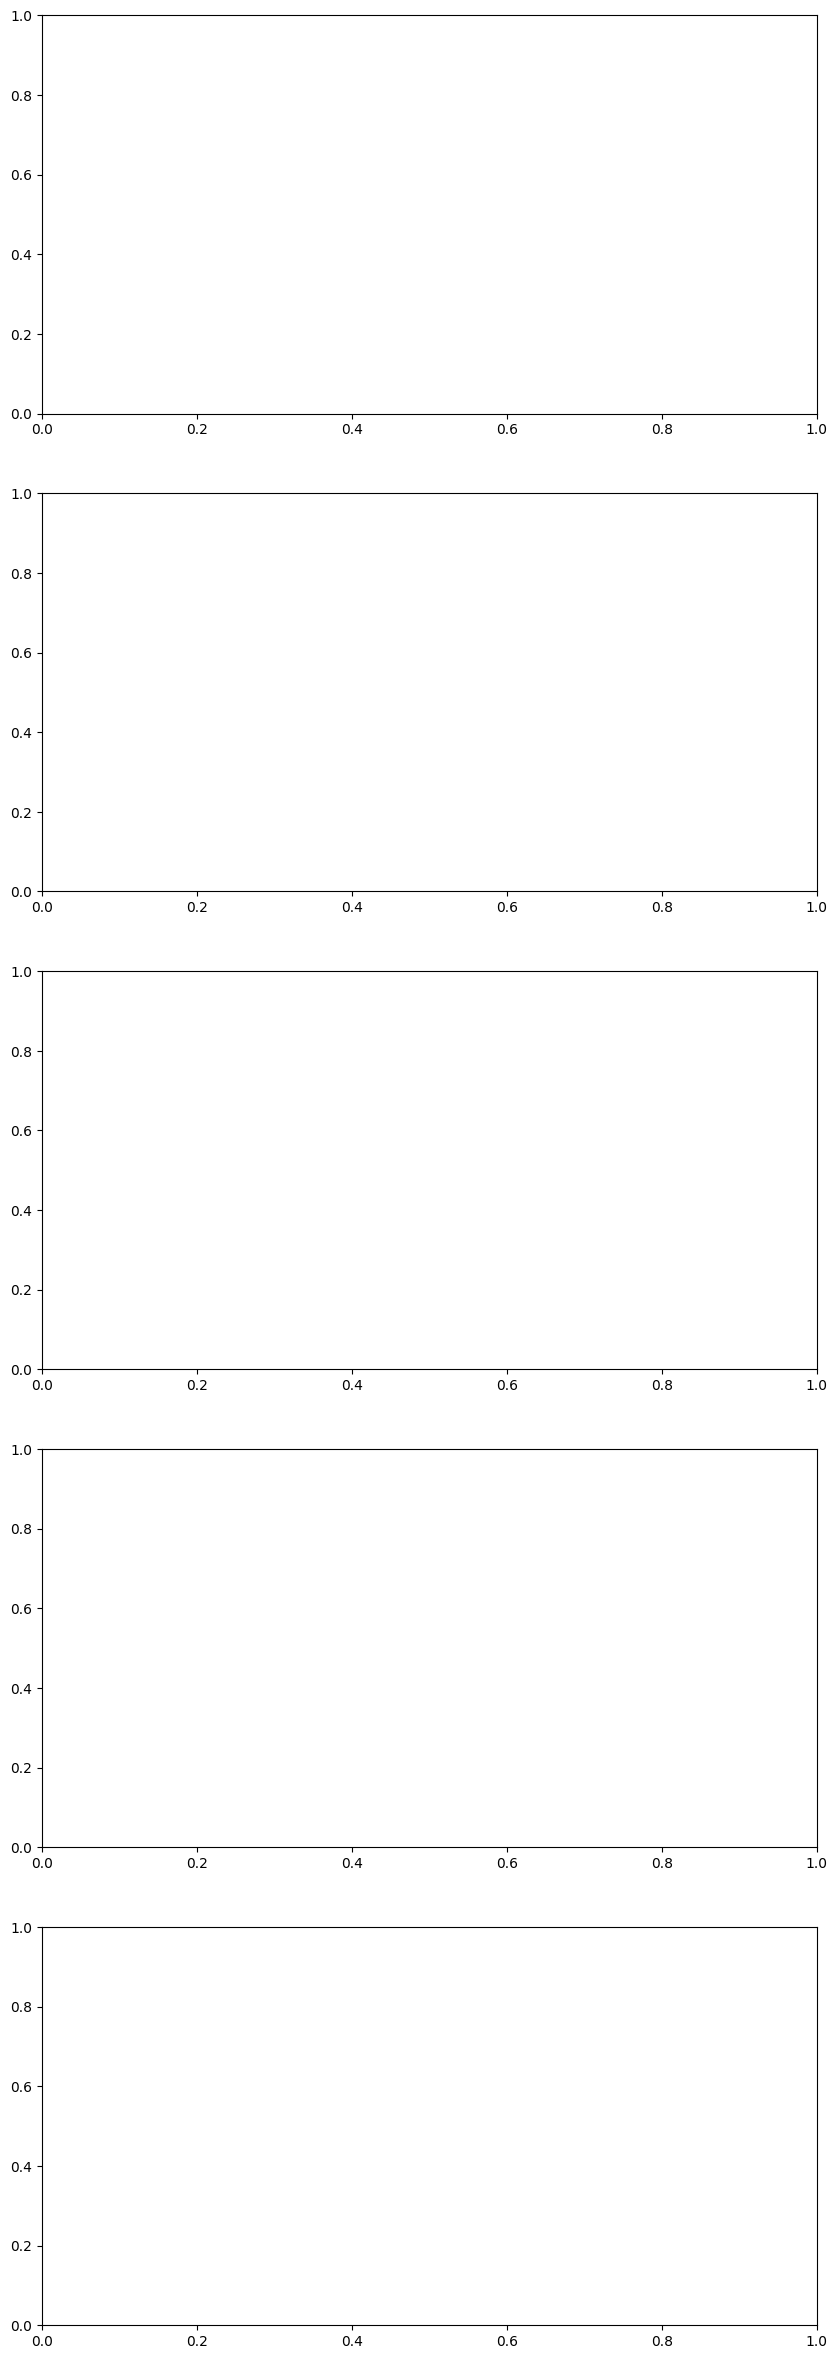

In [13]:
# Make figure of CSF/SC signal ratio from T2starw scan

# Go back to root data folder
os.chdir(path_data)

def smooth_data(data, window_size=50):
    """ Apply a simple moving average to smooth the data. """
    return uniform_filter1d(data, size=window_size, mode='nearest')

# Fixed grid for x-axis
x_grid = np.linspace(0, 1, 100)

# z-slices corresponding to levels C3 to T2 on the PAM50 template. These will be used to scale the x-label of each subject.
original_vector = np.array([907, 870, 833, 800, 769, 735, 692, 646])

# Normalize the PAM50 z-slice numbers to the 1-0 range (to show inferior-superior instead of superior-inferior)
min_val = original_vector.min()
max_val = original_vector.max()
normalized_vector = 1 - ((original_vector - min_val) / (max_val - min_val))

# Use this normalized vector as x-ticks
custom_xticks = normalized_vector

# Vertebral level labels
vertebral_levels = ["C3", "C4", "C5", "C6", "C7", "T1", "T2"]
label_positions = normalized_vector[:-1] + np.diff(normalized_vector) / 2

# Number of subjects determines the number of rows in the subplot
n_rows = len(subjects)

# Create a figure with multiple subplots
fig, axes = plt.subplots(n_rows, 1, figsize=(10, 6 * n_rows))
font_size = 18
line_width = 3

# Check if axes is an array or a single object
if n_rows == 1:
    axes = [axes]

# Data storage for statistics
data_stats = []

# Data storage for Plotly
t2_data_plotly = {}

# Iterate over each subject and create a subplot
for i, subject in enumerate(subjects):
    ax = axes[i]
    t2_data_plotly[subject]={}
    for shim_mode in shim_modes:
        # Initialize list to collect data for this shim method
        method_data = []

        # Get signal in SC
        file_csv = os.path.join(path_results, f"{subject}_acq-{shim_mode}_T2starw_label-SC.csv")
        df = pd.read_csv(file_csv)
        data_sc = df['WA()']
        data_sc_smoothed = smooth_data(data_sc)

        # Get signal in CSF
        file_csv = os.path.join(path_results, f"{subject}_acq-{shim_mode}_T2starw_label-CSF.csv")
        df = pd.read_csv(file_csv)
        data_csf = df['WA()']
        data_csf_smoothed = smooth_data(data_csf)
        
        # Compute ratio
        data_sc_csf_ratio = data_csf_smoothed / data_sc_smoothed

        # Normalize the x-axis to a 1-0 scale for each subject (to go from superior-inferior direction)
        x_subject = np.linspace(1, 0, len(data_sc_csf_ratio))

        # Interpolate to the fixed grid
        interp_func = interp1d(x_subject, data_sc_csf_ratio, kind='linear', bounds_error=False, fill_value='extrapolate')
        resampled_data = interp_func(x_grid)

        method_data.append(resampled_data)

        # If there's data for this shim method, plot it and compute stats
        if method_data:
            t2_data_plotly[subject][shim_mode]=method_data

            # Plotting each file's data separately
            for resampled_data in method_data:
                ax.plot(x_grid, resampled_data, label=f"{shim_mode}", linewidth=line_width)

        
            # Compute stats on the non-resampled data (to avoid interpolation errors)
            mean_data = np.mean(data_sc_csf_ratio)
            sd_data = np.std(data_sc_csf_ratio)
            data_stats.append([subject, shim_mode, mean_data, sd_data])
        else:
            t2_data_plotly[subject][shim_mode]=None

    # Set x-ticks and labels for the bottom subplot
    if i == n_rows - 1:  # Check if it's the last subplot
        # Create a secondary axis for vertebral level labels
        secax = ax.secondary_xaxis('bottom')
        secax.set_xticks(label_positions)
        secax.set_xticklabels(vertebral_levels, fontsize=font_size-4)
        secax.tick_params(axis='x', which='major', length=0)  # Hide tick marks

    ax.set_xticks(custom_xticks)
    ax.set_xticklabels([''] * len(custom_xticks))
    ax.tick_params(axis='x', which='major', length=0)  # Hide tick marks for the primary axis

    ax.set_title(f'{subject}', fontsize=font_size)
    ax.set_ylabel('CSF/Cord T2starw signal ratio', fontsize=font_size)
    ax.tick_params(axis='y', which='major', labelsize=font_size-4)

    # Add legend only to the first subplot
    if i == 0:
        ax.legend(fontsize=font_size)

    ax.grid(True)

# Adjust the layout so labels and titles do not overlap
plt.tight_layout()
plt.savefig(os.path.join(path_results, 'fig_gre_csf-sc_ratio.png'), dpi=300, format='png')
plt.show()

Perform statistics

In [ ]:
# Perform statistics

# Convert to DataFrame and save to CSV
df_stats = pd.DataFrame(data_stats, columns=['Subject', 'Shim_Mode', 'Average', 'Standard_Deviation'])
df_stats.to_csv(os.path.join(path_results, 'stats_t2starw.csv'), index=False)

# Compute statistics across subjects
grouped_means = df_stats.groupby('Shim_Mode').agg({'Average': ['mean', 'std'], 'Standard_Deviation': ['mean', 'std']})

# Format mean ± standard deviation
grouped_means['Average_formatted'] = grouped_means['Average']['mean'].map("{:.2f}".format) + " ± " + grouped_means['Average']['std'].map("{:.2f}".format)
grouped_means['Standard_Deviation_formatted'] = grouped_means['Standard_Deviation']['mean'].map("{:.2f}".format) + " ± " + grouped_means['Standard_Deviation']['std'].map("{:.2f}".format)

# Drop multi-level index and only keep formatted columns
grouped_means = grouped_means.drop(columns=['Average', 'Standard_Deviation'])
grouped_means.columns = ['Average', 'Standard_Deviation']  # Rename columns for clarity
grouped_means.reset_index().to_csv(os.path.join(path_results, 'stats_t2starw_average_across_subjects.csv'), index=False)

# Perform Repeated Measures ANOVA
aovrm = AnovaRM(df_stats, 'Average', 'Subject', within=['Shim_Mode'])
res = aovrm.fit()
print(res.summary())

# Perform Post Hoc paired t-tests

# Filter out subjects that don't have all shim modes
shim_modes = df_stats['Shim_Mode'].unique()
valid_subjects = df_stats.groupby('Subject').filter(lambda x: all(mode in x['Shim_Mode'].values for mode in shim_modes))

# Pairwise comparisons
pairs = list(itertools.combinations(shim_modes, 2))
p_values = []

for pair in pairs:
    data1 = valid_subjects[valid_subjects['Shim_Mode'] == pair[0]]['Average']
    data2 = valid_subjects[valid_subjects['Shim_Mode'] == pair[1]]['Average']
    _, p_value = ttest_rel(data1, data2)
    p_values.append(p_value)

# Function for Benjamini-Hochberg FDR correction
def benjamini_hochberg(p_values):
    n = len(p_values)
    sorted_p_values = np.sort(p_values)
    sorted_index = np.argsort(p_values)
    adjusted_p_values = np.zeros(n)

    for i, p in enumerate(sorted_p_values):
        adjusted_p_values[sorted_index[i]] = min(p * n / (i + 1), 1)

    return adjusted_p_values

# Applying Benjamini-Hochberg FDR correction
adjusted_p_values = benjamini_hochberg(p_values)

# Creating a summary DataFrame
comparison_results = pd.DataFrame({'Pair': pairs, 'P-Value': p_values, 'Adjusted P-Value': adjusted_p_values})

# Save to CSV
comparison_results.to_csv(os.path.join(path_results, 'stats_t2starw_paired_ttest.csv'), index=False)

print(f"Paired t-tests:\n{comparison_results}")

# 6 &nbsp; &nbsp; | &nbsp; &nbsp; Process fmap/TFL (flip angle maps)


Register TFL flip angle maps to the GRE scan ⏳


In [ ]:
if notebook != 'neurolibre-figures':
    for subject in subjects:
        os.chdir(os.path.join(path_data, subject, "fmap"))
        for shim_mode in shim_modes:
            !sct_register_multimodal -i {subject}_acq-anat{shim_mode}_TB1TFL.nii.gz -d ../anat/{subject}_acq-CoV_T2starw_crop.nii.gz -dseg ../anat/{subject}_acq-CoV_T2starw_crop_seg.nii.gz -param step=1,type=im,algo=slicereg,metric=CC -qc {path_qc}

Warping spinal cord segmentation and vertebral level to each flip angle map

In [ ]:
if notebook != 'neurolibre-figures':
    for subject in subjects:
        os.chdir(os.path.join(path_data, subject, "fmap"))
        for shim_mode in shim_modes:
            # Use linear interpolation to preserve partial volume information (needed when extracting values along the cord)
            !sct_apply_transfo -i ../anat/{subject}_acq-CoV_T2starw_crop_seg.nii.gz -d {subject}_acq-anat{shim_mode}_TB1TFL.nii.gz -w warp_{subject}_acq-CoV_T2starw_crop2{subject}_acq-anat{shim_mode}_TB1TFL.nii.gz -x linear -o {subject}_acq-anat{shim_mode}_TB1TFL_seg.nii.gz
            # Use nearest neighbour (nn) interpolation because we are dealing with non-binary discrete labels
            !sct_apply_transfo -i ../anat/{subject}_acq-CoV_T2starw_crop_seg_labeled.nii.gz -d {subject}_acq-anat{shim_mode}_TB1TFL.nii.gz -w warp_{subject}_acq-CoV_T2starw_crop2{subject}_acq-anat{shim_mode}_TB1TFL.nii.gz -x nn -o {subject}_acq-anat{shim_mode}_TB1TFL_seg_labeled.nii.gz

Convert the flip angle maps to B1+ efficiency maps [nT/V] (inspired by code from Kyle Gilbert).

The approach consists in calculating the B1+ efficiency using a 1ms, pi-pulse at the acquisition voltage, then scale the efficiency by the ratio of the measured flip angle to the requested flip angle in the pulse sequence.


In [ ]:

GAMMA = 2.675e8;  # [rad / (s T)]
requested_fa = 90  # saturation flip angle -- hard-coded in sequence

if notebook != 'neurolibre-figures':
    for subject in subjects:
        os.chdir(os.path.join(path_data, subject, "fmap"))
        for shim_mode in shim_modes:
            # Fetch the reference voltage from the JSON sidecar to the TFL B1map sequence
            with open(f"{subject}_acq-famp{shim_mode}_TB1TFL.json", "r") as f:
                metadata = json.load(f)
                ref_voltage = metadata.get("TxRefAmp", "N/A")
                print(f"ref_voltage [V]: {ref_voltage} ({subject}_acq-famp{shim_mode}_TB1TFL)")

            # Open flip angle map with nibabel
            nii = nib.load(f"{subject}_acq-famp{shim_mode}_TB1TFL.nii.gz")
            acquired_fa = nii.get_fdata()

            # Siemens maps are in units of flip angle * 10 (in degrees)
            acquired_fa = acquired_fa / 10

            # Account for the power loss between the coil and the socket. That number was given by Siemens.
            voltage_at_socket = ref_voltage * 10 ** -0.095

            # Compute B1 map in [T/V]
            b1_map = (acquired_fa / requested_fa) * (np.pi / (GAMMA * 1e-3 * voltage_at_socket))

            # Convert to [nT/V]
            b1_map = b1_map * 1e9

            # Save as NIfTI file
            nii_b1 = nib.Nifti1Image(b1_map, nii.affine, nii.header)
            nib.save(nii_b1, f"{subject}_acq-{shim_mode}_TB1map.nii.gz")

Extract B1+ value along the spinal cord between levels C3 and T2 (included)


In [ ]:
if notebook != 'neurolibre-figures':
    for subject in subjects:
        os.chdir(os.path.join(path_data, subject, "fmap"))
        for shim_mode in shim_modes:
            fname_result_b1plus = os.path.join(path_results, f"{subject}_TB1map_{shim_mode}.csv")
            !sct_extract_metric -i {subject}_acq-{shim_mode}_TB1map.nii.gz -f {subject}_acq-anat{shim_mode}_TB1TFL_seg.nii.gz -method wa -vert 3:9 -vertfile {subject}_acq-anat{shim_mode}_TB1TFL_seg_labeled.nii.gz -perslice 1 -o {fname_result_b1plus}

Make figure of B1+ values along the spinal cord across shim methods

In [ ]:
# Go back to root data folder
os.chdir(os.path.join(path_data))

def smooth_data(data, window_size=20):
    """ Apply a simple moving average to smooth the data. """
    return uniform_filter1d(data, size=window_size, mode='nearest')

# Fixed grid for x-axis
x_grid = np.linspace(0, 1, 100)

# z-slices corresponding to levels C3 to T2 on the PAM50 template. These will be used to scale the x-label of each subject.
original_vector = np.array([907, 870, 833, 800, 769, 735, 692, 646])

# Normalize the PAM50 z-slice numbers to the 1-0 range (to show inferior-superior instead of superior-inferior)
min_val = original_vector.min()
max_val = original_vector.max()
normalized_vector = 1 - ((original_vector - min_val) / (max_val - min_val))

# Use this normalized vector as x-ticks
custom_xticks = normalized_vector

# Vertebral level labels
vertebral_levels = ["C3", "C4", "C5", "C6", "C7", "T1", "T2"]
# Calculate midpoints for label positions
label_positions = normalized_vector[:-1] + np.diff(normalized_vector) / 2

# Number of subjects determines the number of rows in the subplot
n_rows = len(subjects)

# Create a figure with multiple subplots
fig, axes = plt.subplots(n_rows, 1, figsize=(10, 6 * n_rows))
font_size = 18
line_width = 3

# Check if axes is an array or a single object
if n_rows == 1:
    axes = [axes]

# Data storage for statistics
data_stats = []

# Data storage for Plotly
b1_data_plotly = {}

# Iterate over each subject and create a subplot
for i, subject in enumerate(subjects):
    
    ax = axes[i]
    
    os.chdir(os.path.join(path_data, subject, "fmap"))
    b1_data_plotly[subject]={}
    
    for shim_mode in shim_modes:
        # Initialize list to collect data for this shim method
        method_data = []

        file_csv = os.path.join(path_results, f"{subject}_TB1map_{shim_mode}.csv")
        df = pd.read_csv(file_csv)
        wa_data = df['WA()']

        # Normalize the x-axis to a 1-0 scale for each subject (to go from superior-inferior direction)
        x_subject = np.linspace(1, 0, len(wa_data))

        # Interpolate to the fixed grid
        interp_func = interp1d(x_subject, wa_data, kind='linear', bounds_error=False, fill_value='extrapolate')
        resampled_data = interp_func(x_grid)

        # Apply smoothing
        smoothed_data = smooth_data(resampled_data)

        method_data.append(smoothed_data)

        # If there's data for this shim method, plot it
        if method_data:
            # Plotting each file's data separately
            for resampled_data in method_data:
                b1_data_plotly[subject][shim_mode]=resampled_data
                ax.plot(x_grid, resampled_data, label=f"{shim_mode}", linewidth=line_width)

            # Compute stats on the non-resampled data (to avoid interpolation errors)
            mean_data = np.mean(wa_data)
            sd_data = np.std(wa_data)
            data_stats.append([subject, shim_mode, mean_data, sd_data])
        else:
            b1_data_plotly[subject][shim_mode]=None


    # Set x-ticks and labels for the bottom subplot
    if i == n_rows - 1:  # Check if it's the last subplot
        # Create a secondary axis for vertebral level labels
        secax = ax.secondary_xaxis('bottom')
        secax.set_xticks(label_positions)
        secax.set_xticklabels(vertebral_levels, fontsize=font_size-4)
        secax.tick_params(axis='x', which='major', length=0)  # Hide tick marks

    ax.set_xticks(custom_xticks)
    ax.set_xticklabels([''] * len(custom_xticks))
    ax.tick_params(axis='x', which='major', length=0)  # Hide tick marks for the primary axis

    ax.set_title(f'{subject}', fontsize=font_size)
    ax.set_ylabel('B1+ efficiency [nT/V]', fontsize=font_size)
    ax.tick_params(axis='y', which='major', labelsize=font_size-4)

    # Add legend only to the first subplot
    if i == 0:
        ax.legend(fontsize=font_size)

    ax.grid(True)

# Adjust the layout so labels and titles do not overlap
plt.tight_layout()
plt.savefig(os.path.join(path_results, 'fig_b1plus.png'), dpi=300, format='png')
plt.show()

Perform statistics

In [ ]:
# Convert to DataFrame and save to CSV
df_stats = pd.DataFrame(data_stats, columns=['Subject', 'Shim_Mode', 'Average', 'Standard_Deviation'])
df_stats.to_csv(os.path.join(path_results, 'stats_b1plus.csv'), index=False)

# Compute statistics across subjects
grouped_means = df_stats.groupby('Shim_Mode').agg({'Average': ['mean', 'std'], 'Standard_Deviation': ['mean', 'std']})

# Format mean ± standard deviation
grouped_means['Average_formatted'] = grouped_means['Average']['mean'].map("{:.2f}".format) + " ± " + grouped_means['Average']['std'].map("{:.2f}".format)
grouped_means['Standard_Deviation_formatted'] = grouped_means['Standard_Deviation']['mean'].map("{:.2f}".format) + " ± " + grouped_means['Standard_Deviation']['std'].map("{:.2f}".format)

# Drop multi-level index and only keep formatted columns
grouped_means = grouped_means.drop(columns=['Average', 'Standard_Deviation'])
grouped_means.columns = ['Average', 'Standard_Deviation']  # Rename columns for clarity
grouped_means.reset_index().to_csv(os.path.join(path_results, 'stats_b1plus_average_across_subjects.csv'), index=False)

# Perform Repeated Measures ANOVA
aovrm = AnovaRM(df_stats, 'Average', 'Subject', within=['Shim_Mode'])
res = aovrm.fit()
print(res.summary())

# Perform Post Hoc paired t-tests

# Filter out subjects that don't have all shim modes
shim_modes = df_stats['Shim_Mode'].unique()
valid_subjects = df_stats.groupby('Subject').filter(lambda x: all(mode in x['Shim_Mode'].values for mode in shim_modes))

# Pairwise comparisons
pairs = list(itertools.combinations(shim_modes, 2))
p_values = []

for pair in pairs:
    data1 = valid_subjects[valid_subjects['Shim_Mode'] == pair[0]]['Average']
    data2 = valid_subjects[valid_subjects['Shim_Mode'] == pair[1]]['Average']
    _, p_value = ttest_rel(data1, data2)
    p_values.append(p_value)

# Function for Benjamini-Hochberg FDR correction
def benjamini_hochberg(p_values):
    n = len(p_values)
    sorted_p_values = np.sort(p_values)
    sorted_index = np.argsort(p_values)
    adjusted_p_values = np.zeros(n)

    for i, p in enumerate(sorted_p_values):
        adjusted_p_values[sorted_index[i]] = min(p * n / (i + 1), 1)

    return adjusted_p_values

# Applying Benjamini-Hochberg FDR correction
adjusted_p_values = benjamini_hochberg(p_values)

# Creating a summary DataFrame
comparison_results = pd.DataFrame({'Pair': pairs, 'P-Value': p_values, 'Adjusted P-Value': adjusted_p_values})

# Save to CSV
comparison_results.to_csv(os.path.join(path_results, 'stats_b1plus_paired_ttest.csv'), index=False)

print(f"Paired t-tests:\n{comparison_results}")

# 7 &nbsp; &nbsp; | &nbsp; &nbsp; Paper figures

Prepare RF shimming mask for figure


In [ ]:
# Select subject to show
subject = 'sub-05'
os.chdir(os.path.join(path_data, subject, "fmap"))

# Create RF shimming mask from the segmentation (re-create the live RF shimming procedure)
file_mask = f"{subject}_acq-anatCP_TB1TFL_mask-shimming.nii.gz"
if notebook != 'neurolibre-figures':

    !sct_maths -i {subject}_acq-anatCP_TB1TFL_seg_labeled.nii.gz -thr 3 -uthr 9 -o {file_mask}
    !sct_maths -i {file_mask} -bin 1 -o {file_mask}
    !sct_create_mask -i {subject}_acq-anatCP_TB1TFL.nii.gz -p centerline,{file_mask} -size 28mm -f cylinder -o {file_mask}

    # Dilate mask
    !sct_maths -i {file_mask} -dilate 2 -shape disk -dim 2 -o {subject}_acq-anatCP_TB1TFL_mask-shimming_dil.nii.gz
    # Subtract dilated mask with mask to get the edge
    !sct_maths -i {subject}_acq-anatCP_TB1TFL_mask-shimming_dil.nii.gz -sub {file_mask} -o {file_mask}

Create figure of B1+ maps

In [ ]:
# Select subject to show
subject = 'sub-05'
os.chdir(os.path.join(path_data, subject, "fmap"))
file_mask = f"{subject}_acq-anatCP_TB1TFL_mask-shimming.nii.gz"

# Load the statistics from the CSV file
stats_df = pd.read_csv(os.path.join(path_results, 'stats_b1plus.csv'))

# Filter for the specific subject
subject_stats = stats_df[stats_df['Subject'] == subject]

# Defining crop limits for resulting figure
xmin = 20
xmax = 110
ymin = 20
ymax = 150

# Defining dynamic range
dynmin = 5 
dynmax = 30

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 4, figsize=(8, 6))
font_size = 14
axes=axes.flatten()

# First, plot the anatomical image with an overlay of the mask

# Load data
CP_anat=nib.load(f"{subject}_acq-anatCP_TB1TFL.nii.gz")
CP_SC=nib.load(file_mask)
CP_nTpV=nib.load(f"{subject}_acq-CP_TB1map.nii.gz")

# Defining mask based on the magnitude image intensity threshold
cslice=CP_anat.shape[2] // 2 -2 #shows the SC seg best
threshold=300
mask=CP_anat.get_fdata()[xmin:xmax,ymin:ymax, cslice]
mask=np.where(mask > threshold, 1, 0)

# Cropping anat, SC, B1+
CP_anat=CP_anat.get_fdata()[xmin:xmax,ymin:ymax, cslice]
CP_anat=CP_anat*mask
CP_SC=CP_SC.get_fdata()[xmin:xmax,ymin:ymax, cslice]
CP_nTpV=CP_nTpV.get_fdata()[xmin:xmax,ymin:ymax, cslice]
CP_nTpV=CP_nTpV*mask

# All opacity overalys look ugly: workaround, set the anat slice to a max value where the segmentation exists
CP_anat[CP_SC>0.5]=4000;

# Plotting anat overlayed with SC
splot=axes[0]
splot.imshow((CP_anat.T), cmap='gray', origin='lower',vmin=0,vmax=2000)#, interpolation='spline36')
splot.set_title('Anat', size=font_size)
splot.axis('off')

# Then, plot each B1+ map, with an overlay of the mean and CV inside the cord
for i,shim_mode in enumerate(shim_modes):
    # Load data
    B1map=nib.load(f"{subject}_acq-{shim_mode}_TB1map.nii.gz")
    B1map=B1map.get_fdata()[xmin:xmax,ymin:ymax, cslice]
    B1map=B1map*mask

    # Plot
    splot=axes[i+1]
    im = splot.imshow((B1map.T), cmap='viridis', origin='lower',vmin=dynmin,vmax=dynmax)#, interpolation='spline36')
    splot.set_title(shim_mode, size=font_size)
    splot.axis('off')

    # Find the statistics for the current shim mode
    shim_stats = subject_stats[subject_stats['Shim_Mode'] == shim_mode]
    if not shim_stats.empty:
        mean_val = shim_stats.iloc[0]['Average']
        std_val = shim_stats.iloc[0]['Standard_Deviation']
        cv = std_val / mean_val * 100  # Coefficient of variation in percentage
        annotation_text = f"{mean_val:.2f} nT/V\n{cv:.2f}%"
        splot.annotate(annotation_text, (0.05, 0.95), xycoords='axes fraction', 
                       fontsize=10, color='white', 
                       verticalalignment='top', horizontalalignment='left')

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0, right=0.9)

# Colorbar
# Assume that the colorbar should start at the bottom of the lower row of subplots and
# extend to the top of the upper row of subplots
cbar_bottom = 0.06  # This might need adjustment
cbar_height = 0.83  # This represents the total height of both rows of subplots
cbar_ax = fig.add_axes([0.93, cbar_bottom, 0.03, cbar_height])
cbar = plt.colorbar(im, cax=cbar_ax)

# cbar_ax = fig.add_axes([0.95, 0.5, 0.04, 0.4])
# cbar = plt.colorbar(im, cax=cbar_ax)
cbar_ax.set_title('nT/V', size=12)
plt.savefig(os.path.join(path_results, 'fig_b1plus_map.png'), dpi=300, format='png')
plt.show()


<b>Figure 2.</b> B1+ efficiency for one participant (sub-05) across all seven RF shimming conditions. The top left panel shows the tfl_b1map magnitude image with an overlay of the mask that was used to perform RF shimming. Text inserts show the mean (in nT/V) and CoV (in %) of B1+ efficiency along the spinal cord between C3 and T2. 

In [ ]:
# PYTHON CODE
# Module imports

# Base python
import os
from os import path
from pathlib import Path

# Graphical

import plotly.graph_objs as go
from IPython.display import display, HTML
from plotly import __version__
from plotly.offline import init_notebook_mode, iplot, plot
config={
    'showLink': False,
    'displayModeBar': False,
    'toImageButtonOptions': {
                'format': 'png', # one of png, svg, jpeg, webp
                'filename': 'custom_image',
                'height': 2500,
                'width': 500,
                'scale': 2 # Multiply title/legend/axis/canvas sizes by this factor
            }
    }

init_notebook_mode(connected=True)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import seaborn as sns

# Set the color palette
pal=sns.color_palette()

# Imports
import warnings
warnings.filterwarnings("ignore")

## Setup for plots
fig = make_subplots(rows=5, cols=2, vertical_spacing = 0.025,
                    subplot_titles=(
    '<b>sub-01</b>',
    '<b>sub-01</b>',
    '<b>sub-02</b>',
    '<b>sub-02</b>',
    '<b>sub-03</b>',
    '<b>sub-03</b>',
    '<b>sub-04</b>',
    '<b>sub-04</b>',
    '<b>sub-05</b>',
    '<b>sub-05</b>',))

t2_datasets={}
b1_datasets={}

t2_data = []
b1_data = []

legend_bool = True
for subject in subjects:
    index = 0
    t2_datasets[subject]={}
    b1_datasets[subject]={}

    for shim_mode in shim_modes:
        t2_datasets[subject][shim_mode]={}
        b1_datasets[subject][shim_mode]={}

        t2_data=go.Line(
            x=x_grid,
            y=t2_data_plotly[subject][shim_mode][0],
            name=shim_mode,
            legendgroup=shim_mode,
            line=dict(color='rgb'+str(pal[index]), width=3),
            showlegend=False
            )

        b1_data=go.Line(
            x=x_grid,
            y=b1_data_plotly[subject][shim_mode],
            name=shim_mode,
            legendgroup=shim_mode,
            line=dict(color='rgb'+str(pal[index]), width=3),
            showlegend=legend_bool
            )        

        
        t2_datasets[subject][shim_mode]=t2_data
        b1_datasets[subject][shim_mode]=b1_data

        index += 1
    legend_bool=False
    

index = 1
# For z-ordering   
for subject in subjects:
    for shim_mode in shim_modes:
        fig.add_trace(
            t2_datasets[subject][shim_mode],
            row=index, col=1
        )
        fig.add_trace(
            b1_datasets[subject][shim_mode],
            row=index, col=2
        )
    index+=1


index = 1
for subject in subjects:
    if index == 5:
        x_title = '<b>Vertebral Levels</b>'
        showticklabels=True
    else:
        x_title = None
        showticklabels=False

    fig.update_xaxes(
        type="linear",
        autorange=True,
        title=x_title,
        showgrid=True,
        gridcolor='rgb(169,169,169)',
        tickvals=label_positions,
        ticktext=vertebral_levels,
        showticklabels=showticklabels,
        title_font_family="Times New Roman",
        title_font_size = 20,
        linecolor='black',
        linewidth=2,
        tickfont=dict(
            family='Times New Roman',
            size=16,
        ),
        row=index, col=1
        )
    if index == 1:
        fig.update_yaxes(
            type="linear",
            title={
                'text':'<b>CSF/Cord T<sub>2</sub><sup>*</sup>w signal ratio</b>',
                'standoff':0
                },
            range=[1.05, 1.4],
            showgrid=True,
            gridcolor='rgb(169,169,169)',
            title_font_family="Times New Roman",
            title_font_size = 20,
            linecolor='black',
            linewidth=2,
            tickfont=dict(
                family='Times New Roman',
                size=16,
            ),
            row=index, col=1
            )
    else:
        fig.update_yaxes(
            type="linear",
            title={
                'text':'<b>CSF/Cord T<sub>2</sub><sup>*</sup>w signal ratio</b>',
                'standoff':0
                },
            showgrid=True,
            gridcolor='rgb(169,169,169)',
            title_font_family="Times New Roman",
            title_font_size = 20,
            linecolor='black',
            linewidth=2,
            tickfont=dict(
                family='Times New Roman',
                size=16,
            ),
            row=index, col=1
            )

    fig.update_xaxes(
        type="linear",
        autorange=True,
        title=x_title,
        showgrid=True,
        gridcolor='rgb(169,169,169)',
        tickvals=label_positions,
        ticktext=vertebral_levels,
        showticklabels=showticklabels,
        title_font_family="Times New Roman",
        title_font_size = 20,
        linecolor='black',
        linewidth=2,
        tickfont=dict(
            family='Times New Roman',
            size=16,
        ),
        row=index, col=2
        )
    fig.update_yaxes(
        type="linear",
        title={
            'text':'<b>B<sub>1</sub><sup>+</sup> efficiency [nT/V]</b>',
            'standoff':0
            },
        showgrid=True,
        gridcolor='rgb(169,169,169)',
        title_font_family="Times New Roman",
        title_font_size = 20,
        linecolor='black',
        linewidth=2,
        tickfont=dict(
            family='Times New Roman',
            size=16,
        ),
        row=index, col=2
        )

    index+=1

fig.update_layout(height=1800, width=900)

for i in fig['layout']['annotations']:
    i['font'] = dict(size=22)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.999,
    xanchor="left",
    x=0.01,
    font=dict(
        family='Times New Roman',
        size=12
    ),
    bordercolor="Black",
    borderwidth=1.5
    ),
    legend_tracegroupgap=0,
    paper_bgcolor='rgb(255, 255, 255)',
    plot_bgcolor='rgb(255, 255, 255)',
)

fig.add_annotation(
        dict(
            x=-0.07,
            y=-0.04,
            showarrow=False,
            text='<b>A</b>',
            font=dict(
                family='Times New Roman',
                size=48
            ),
            xref='paper',
            yref='paper'
        ))
fig.add_annotation(
        dict(
            x=0.5,
            y=-0.04,
            showarrow=False,
            text='<b>B</b>',
            font=dict(
                family='Times New Roman',
                size=48
            ),
            xref='paper',
            yref='paper'
        ),
)
#iplot(fig, filename = 'figure4a', config = config)
plot(fig, filename = 'figure1.html', config = config)


In [ ]:
display(HTML('figure1.html'))

<b>Figure 3.</b> B<sub>1</sub><sup>+</sup> efficiency (A) and CSF/Cord signal ratio from the GRE scan (B) across subjects and across different RF shimming conditions. Data were measured in the spinal cord from C3 to T2 vertebral levels. To match the x-ticks across subjects, the C2-C3 and the T2-T3 intervertebral discs of each subject were aligned with that of the PAM50 template  {cite:p}`DELEENER2018170`, and the curves were linearly scaled.


# References 

```{bibliography}
:filter: docname in docnames
```

In [ ]:
# Indicate duration of data processing

end_time = datetime.now()
total_time = (end_time - start_time).total_seconds()

# Convert seconds to a timedelta object
total_time_delta = timedelta(seconds=total_time)

# Format the timedelta object to a string
formatted_time = str(total_time_delta)

# Pad the string representation if less than an hour
formatted_time = formatted_time.rjust(8, '0')

print(f"Total Runtime [hour:min:sec]: {formatted_time}")